In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# default_exp query

# Query

This is an interface to *querying* resources that can be fetched.

It covers local files, the [Common Crawl Index](http://commoncrawl.org/2015/04/announcing-the-common-crawl-index/) and the [Internet Archive's CDX Server](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server) for finding archived resources based on URL patterns.
The latter two have  a lot of overlap with [cdx_toolkit](https://github.com/cocrawler/cdx_toolkit) but this is more optimised for speed and ease of use.

In [3]:
#export
# Typing
from __future__ import annotations # For Python <3.9
from typing import Any, Callable, Generator, Optional, Union
from collections.abc import Iterable
from pathlib import Path
from dataclasses import dataclass

from datetime import datetime

import requests
from requests.sessions import Session
import json

from warcio.recordloader import ArcWarcRecord
import warcio

from webrefine.util import sha1_digest, URL, make_session

# Local WARC Files

## Object

In [4]:
#export

@dataclass(frozen=True)
class WarcFileRecord:
    url: str
    timestamp: datetime
    mime: str
    status: int
    path: Path
    offset: int
    digest: str
        
    def get_content(self):
        with open(self.path, 'rb') as f:
            f.seek(self.offset)
            record = next(warcio.ArchiveIterator(f))
            return record.content_stream().read() 
        
    def preview(self, filename):
        with open(filename, 'wb') as f:
            f.write(self.content)
        return FileLink(filename) 
    
    @property
    def content(self):
        return self.get_content()
    
    # Potential improvement is to keep the file open across records
    @staticmethod
    def fetch_parallel(records):
        return [r.content for r in records]
    
def get_warc_url(record: ArcWarcRecord) -> str:
    return record.rec_headers.get_header('WARC-Target-URI')

_WARC_TIMESTAMP_FORMAT = '%Y-%m-%dT%H:%M:%SZ'
def get_warc_timestamp(record: ArcWarcRecord) -> datetime:
    return datetime.strptime(record.rec_headers.get_header('WARC-Date'), _WARC_TIMESTAMP_FORMAT)

def get_warc_mime(record: ArcWarcRecord) -> str:
    return record.http_headers.get_header('Content-Type').split(';')[0]

def get_warc_status(record: ArcWarcRecord) -> int:
    return int(record.http_headers.get_statuscode())

def get_warc_digest(record: ArcWarcRecord) -> str:
    digest = record.rec_headers.get_header('WARC-Payload-Digest')
    prefix = 'sha1:'
    if not digest.startswith(prefix):
        raise ValueError('Expected %s to start with %s', digest, prefix)
    return digest[len(prefix):]

class WarcFileQuery:
    def __init__(self, path: Union[str, Path]) -> None:
        self.path = Path(path)
        
    def query(self) -> Generator[WarcRecord, None, None]:
        results = []
        with open(self.path, 'rb') as f:
            archive = warcio.ArchiveIterator(f)
            for record in archive:
                if record.rec_type != 'response':
                    continue
                warc_record = WarcFileRecord(url=get_warc_url(record),
                                         timestamp=get_warc_timestamp(record),
                                         mime = get_warc_mime(record),
                                         status = get_warc_status(record),
                                         digest = get_warc_digest(record),
                                         offset = archive.get_record_offset(),
                                         path = self.path)
                                         
                                         
                results.append(warc_record)
        return results

## Testing

Generated some test data with:

```
wget -r -Q1M --domains skeptric.com --warc-file=skeptric --delete-after --no-directories https://skeptric.com/pagination-wayback-cdx/
```

See [warcio library](https://github.com/webrecorder/warcio#writing-warc-records) for how to do this in Python.

In [5]:
test_data = '../resources/test/skeptric.warc.gz'

In [6]:
warc = WarcFileQuery(test_data)
results = warc.query()
results

[WarcFileRecord(url='https://skeptric.com/pagination-wayback-cdx/', timestamp=datetime.datetime(2021, 11, 26, 11, 28, 34), mime='text/html', status=200, path=PosixPath('../resources/test/skeptric.warc.gz'), offset=889, digest='Q6HKH563Z7HF2333QILSSSHY2K3B6NOK'),
 WarcFileRecord(url='https://skeptric.com/robots.txt', timestamp=datetime.datetime(2021, 11, 26, 11, 28, 34), mime='text/html', status=404, path=PosixPath('../resources/test/skeptric.warc.gz'), offset=5804, digest='QRNGXIUXE4LAI3XR5RVATIUX5GTB33HX'),
 WarcFileRecord(url='https://skeptric.com/style.main.min.5ea2f07be7e07e221a7112a3095b89d049b96c48b831f16f1015bf2d95d914e5.css', timestamp=datetime.datetime(2021, 11, 26, 11, 28, 35), mime='text/css', status=200, path=PosixPath('../resources/test/skeptric.warc.gz'), offset=7197, digest='LINCDTSPQGAQGZZ6LY2XFXZHG2X476H6'),
 WarcFileRecord(url='https://skeptric.com/', timestamp=datetime.datetime(2021, 11, 26, 11, 28, 36), mime='text/html', status=200, path=PosixPath('../resources/test

Try fetching a record

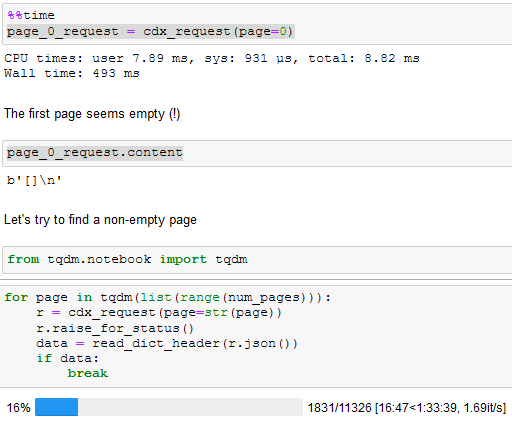

In [7]:
image_record = [r for r in results if r.mime == 'image/png'][0]

content = image_record.content
from IPython.display import Image
Image(content)

Check the digests

In [8]:
for result in results:
    assert result.digest == sha1_digest(result.get_content())

# Internet Archive


## Querying CDX

The Internet Archive runs it's own [Java CDX Server](https://github.com/internetarchive/wayback/tree/master/wayback-cdx-server). [Hakernoon has an article](https://hackernoon.com/guide-to-handling-internet-archives-cdx-server-api-response-c469df5b81f4) that gives a good overview of querying it.

See the documentation for all the paramemters; here are the ones that I find most interesting

* url: The URL to query, a wildcard `*` can implicitly define it (which means we don't need `matchType`)
* output: "json" returns JSON instead of space separated
* fl: Comma separated list of fields to return
* from, to: Date filtering 1-14 digits yyyyMMddhhmmss, inclusive (this seems to do the right thing for truncation).
* filter: `[!]field:regex` filter a returned field with [Java Regex](https://docs.oracle.com/javase/6/docs/api/java/util/regex/Pattern.html), inverting with `!`
* limit/offset: For getting a small number of results (sampling). Internal limit is 150000 results.

Default fields returned: ["urlkey","timestamp","original","mimetype","statuscode","digest","length"]

Pagination isn't really useful because it's applied *before* filtering (including date filtering) so most pages are empty with a date filter.
Unpaginated requests are fast enough anyway.

### Exporting the data

The data is a JSON array or arrays; the first line contains the headers and the subsequent the data.
Let's transform it into a list of dictionaries of keys to values which make it a bit easier to work with (although less efficient in memory).

An alternative would be to directly use something like Pandas

In [9]:
#export
def header_and_rows_to_dict(rows: Iterable[list[Any]]) -> list[dict[Any, Any]]:
    header = None
    data = []
    for row in rows:
        if header is None:
            header = row
        else:
            assert len(row) == len(header), "Row should be same length as header"
            data.append(dict(zip(header, row)))
    return data

Check it on some data

In [10]:
assert header_and_rows_to_dict([['col_1', 'col_2'], [1, 'a'], [2, 'b']]) == [
    {'col_1': 1, 'col_2': 'a'},
    {'col_1': 2, 'col_2': 'b'}]

In [11]:
assert header_and_rows_to_dict([['col_1', 'col_2']]) == []

In [12]:
assert header_and_rows_to_dict([]) == []

### Making a query

In [13]:
#export
IA_CDX_URL = 'http://web.archive.org/cdx/search/cdx'

# This could be more precise
CaptureIndexRecord = dict

def mimetypes_to_regex(mime: list[str], prefix='mimetype:') -> str:
    return prefix + '|'.join('(' + s.replace('*', '.*') + ')' for s in mime)

def query_wayback_cdx(url: str, start: Optional[str], end: Optional[str],
                      status_ok: bool = True, 
                      mime: Optional[Union[str, Iterable[str]]] = None,
                      limit: Optional[int] = None, offset: Optional[int] = None,
                      session: Optional[Session] = None) -> list[CaptureIndexRecord]:
    """Get references to Wayback Machine Captures for url.
    
    Queries the Internet Archive Capture Index (CDX) for url.
    
    Arguments:
      * start: Minimum date in format YYYYmmddHHMMSS (or any substring) inclusive
      * end: Maximum date in format YYYYmmddHHMMSS (or any substring) inclusive
      * status_ok: Only return those with a HTTP status 200
      * mime: Filter on mimetypes, '*' is a wildcard (e.g. 'image/*')
      * limit: Only return first limit records
      * offset: Skip the first offset records, combine with limit
      * session: Session to use when making requests
    Filters results between start and end inclusive, in format YYYYmmddHHMMSS or any substring
    (e.g. start="202001", end="202001" will get all captures in January 2020)
    """
    if session is None:
        session = requests
        
    params = {'url': url,
              'output': 'json',
              'from': start,
              'to': end,
              'limit': limit,
              'offset': offset}
    
    filter = []
    if status_ok:
        filter.append('statuscode:200')
    if mime:
        # Turn our list of mimetypes into a regex
        if isinstance(mime, str):
            mime = [mime]
        filter.append(mimetypes_to_regex(mime))
    params['filter'] = filter
    
    params = {k:v for k,v in params.items() if v}
    response = session.get(IA_CDX_URL, params=params)
    response.raise_for_status()
    return header_and_rows_to_dict(response.json())

#### Test querying

In [14]:
%%time
full_sample = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False)

CPU times: user 29.7 ms, sys: 7.14 ms, total: 36.8 ms
Wall time: 1.17 s


#### Test statuscode filter

In [15]:
%%time
ok_sample = query_wayback_cdx('skeptric.com/*', start=None, end=None) #status_ok=True

CPU times: user 20.1 ms, sys: 3.37 ms, total: 23.5 ms
Wall time: 928 ms


In [16]:
assert ok_sample == [x for x in full_sample if x['statuscode'] == '200']

#### Test mimetypes

In [17]:
%%time
html_sample = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False, mime='text/html')

CPU times: user 8.03 ms, sys: 6.29 ms, total: 14.3 ms
Wall time: 631 ms


In [18]:
assert html_sample == [x for x in full_sample if x['mimetype'] == 'text/html']

In [19]:
%%time
image_sample = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False, mime='image/*')

CPU times: user 12.9 ms, sys: 3.26 ms, total: 16.2 ms
Wall time: 659 ms


In [20]:
assert image_sample == [x for x in full_sample if x['mimetype'].startswith('image/')]

In [21]:
%%time
prog_sample = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False, 
                                 mime=['text/css', 'application/javascript'])

CPU times: user 7.98 ms, sys: 3.15 ms, total: 11.1 ms
Wall time: 452 ms


In [22]:
assert prog_sample == [x for x in full_sample if x['mimetype'] in ['text/css', 'application/javascript']]

#### Test date filters

In [23]:
%%time
sample_2020 = query_wayback_cdx('skeptric.com/*', start='2020', end='2020', status_ok=False)
len(sample_2020)

CPU times: user 4.74 ms, sys: 3.33 ms, total: 8.08 ms
Wall time: 458 ms


106

In [24]:
assert sample_2020 == [x for x in full_sample if '2020' <= x['timestamp'] < '2021']

In [25]:
%%time
sample_to_2020 = query_wayback_cdx('skeptric.com/*', start=None, end='2020', status_ok=False)

CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 476 ms


In [26]:
assert sample_to_2020 == [x for x in full_sample if x['timestamp'] < '2021']

In [27]:
%%time
sample_from_2020 = query_wayback_cdx('skeptric.com/*', start='2020', end=None, status_ok=False)

CPU times: user 16.2 ms, sys: 13.2 ms, total: 29.4 ms
Wall time: 1 s


In [28]:
assert sample_from_2020 == [x for x in full_sample if x['timestamp'] >= '2020']

#### Test limits

In [29]:
%%time
sample_10 = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False, limit=10)

CPU times: user 4.71 ms, sys: 2.66 ms, total: 7.37 ms
Wall time: 442 ms


In [30]:
sample_10 == full_sample[:10]

True

In [31]:
%%time
sample_10_offset_20 = query_wayback_cdx('skeptric.com/*', start=None, end=None, status_ok=False, limit=10, offset=20)

CPU times: user 5.54 ms, sys: 3.12 ms, total: 8.66 ms
Wall time: 434 ms


In [32]:
assert sample_10_offset_20  == full_sample[20:20+10]

## Fetching Content

The original content is at `http://web.archive.org/web/{timestamp}_id/{url}`, and the Wayback Machine version is the same excluding `_id`.
The Wayback Machine version [makes some changes](https://skeptric.com/restoring-wayback-html/) that make it better for interactive viewing, but the content is different.

In [33]:
#export
def wayback_url(timestamp: str, url: str, wayback: bool = False) -> str:
    postfix = '' if wayback else 'id_'
    return f'http://web.archive.org/web/{timestamp}{postfix}/{url}'

def fetch_wayback_content(timestamp: str, url: str,
                          session: Optional[Session] = None) -> Optional[bytes]:
    if session is None:
        session = requests
        
    url = wayback_url(timestamp, url)
    response = session.get(url)
    # Sometimes Internet Archive deletes records
    if response.status_code == 404:
        logging.warning(f'Missing {url}')
        return None
    response.raise_for_status()
    return response.content

In [34]:
record = image_sample[0]
record

{'urlkey': 'com,skeptric)/favicon.ico',
 'timestamp': '20180819051126',
 'original': 'http://skeptric.com/favicon.ico',
 'mimetype': 'image/vnd.microsoft.icon',
 'statuscode': '200',
 'digest': 'R6YE2GPPT4BM4IAMHGUJPDJF6BGKKHDA',
 'length': '851'}

In [35]:
content = fetch_wayback_content(record['timestamp'], record['original'])

In [36]:
from IPython.display import Image
Image(content)

In [37]:
assert record['digest'] == sha1_digest(content)

And fetching a HTML webpage

In [38]:
record = ok_sample[0]

In [39]:
content = fetch_wayback_content(record['timestamp'], record['original'])

In [40]:
assert record['digest'] == sha1_digest(content)

Get the Wayback URL for preview

In [41]:
URL(wayback_url(record['timestamp'], record['original'], wayback=True))

URL(url='http://web.archive.org/web/20180805132731/http://skeptric.com/')

## Wayback Record Object

In [42]:
#export

_WAYBACK_TIMESTAMP_FORMAT = '%Y%m%d%H%M%S'

@dataclass(frozen=True)
class WaybackRecord:
    url: str
    timestamp: datetime
    mime: str
    status: Optional[int]
    digest: str
        
    def preview(self) -> URL:
        return URL(wayback_url(self.timestamp_str, self.url, wayback=True))

    @property
    def timestamp_str(self) -> str:
        return self.timestamp.strftime(_WAYBACK_TIMESTAMP_FORMAT)
        
    def get_content(self, session=None) -> Optional[bytes]:
        return fetch_wayback_content(self.timestamp_str, self.url, session=None)
    
    @property
    def content(self):
        return self.get_content()
    
    @classmethod
    def from_dict(cls, record: dict):
        return _wayback_cdx_to_record(record)
    

def _wayback_cdx_to_record(record: dict) -> WaybackRecord:
    return WaybackRecord(url = record['original'],
                         timestamp = datetime.strptime(record['timestamp'], _WAYBACK_TIMESTAMP_FORMAT),
                         mime = record['mimetype'],
                         status = None if record['statuscode'] == '-' else int(record['statuscode']),
                         digest = record['digest'])

In [43]:
record = WaybackRecord.from_dict(full_sample[0])
record

WaybackRecord(url='http://skeptric.com/', timestamp=datetime.datetime(2018, 8, 5, 13, 27, 31), mime='text/html', status=200, digest='2N5QQYZFAM36CSESTGSDKRTRV7I5HEXJ')

In [44]:
record.preview()

URL(url='http://web.archive.org/web/20180805132731/http://skeptric.com/')

In [45]:
%%time
content = record.content
content[:100]

CPU times: user 7.08 ms, sys: 0 ns, total: 7.08 ms
Wall time: 372 ms


b'<!DOCTYPE html>\n<html lang="en">\n  <head>\n    <meta charset="utf-8" />\n    <title>Edward Ross - An \xc9'

In [46]:
assert sha1_digest(content) == record.digest

## Wayback Query

In [47]:
#export
@dataclass
class WaybackQuery:
    url: str
    start: Optional[str]
    end: Optional[str]
    status_ok: bool = True
    mime: Optional[Union[str, Iterable[str]]] = None
        
    def query(self,
              limit: Optional[int] = None,
              session: Optional[Session] = None) -> Generator[WaybackRecord, None, None]:
        for r in query_wayback_cdx(self.url, self.start, self.end, self.status_ok, self.mime, limit, session=session):
            yield _wayback_cdx_to_record(r)

#### Test fetching one

In [48]:
wb = WaybackQuery('skeptric.com/*', start=None, end=None)

In [49]:
%%time
items = list(wb.query())

CPU times: user 74.8 ms, sys: 6.06 ms, total: 80.9 ms
Wall time: 1.31 s


In [50]:
assert len(items) > 50

In [51]:
content = items[0].content
assert sha1_digest(content) == items[0].digest

#### Test fetching many

I have no idea whether Session is [actually thread-safe](https://github.com/urllib3/urllib3/issues/1252); if it's not we should have 1 session per thread. As far as I can tell the issue occurs when you have lots of hosts, so in this case it should be ok.

I guess we'll try it and see. Maybe long term we're better going with asyncio.
Using a Session makes things slightly faster; we can always turn it off by passing session=False.

In [52]:
# export

from joblib import delayed, Parallel

def wayback_fetch_parallel(items, threads=8, session=None):
    if session is None:
        session = make_session(threads)
    return Parallel(n_jobs=threads, prefer='threads')(delayed(item.get_content)(session=session) for item in items)

WaybackRecord.fetch_parallel = wayback_fetch_parallel

In [53]:
%%time
contents_16 = WaybackRecord.fetch_parallel(items[:16], threads=8)

CPU times: user 278 ms, sys: 59.9 ms, total: 338 ms
Wall time: 3.57 s


In [54]:
assert contents_16[0] == content

# Common Crawl

Common Crawl is similar, but slightly different, because it is split over many indexes, roughly monthly covering 2 weeks.

## Indexes

Cache within a session, but not between sessions since over months the indexes change.

In [55]:
#export
from functools import lru_cache
@lru_cache(maxsize=None)
def get_cc_indexes() -> List[Dict[str, str]]:
    response = requests.get("https://index.commoncrawl.org/collinfo.json")
    response.raise_for_status()
    return response.json()

In [56]:
indexes = get_cc_indexes()
indexes[:3]

[{'id': 'CC-MAIN-2021-43',
  'name': 'October 2021 Index',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2021-43/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2021-43-index'},
 {'id': 'CC-MAIN-2021-39',
  'name': 'September 2021 Index',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2021-39/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2021-39-index'},
 {'id': 'CC-MAIN-2021-31',
  'name': 'July 2021 Index',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2021-31/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2021-31-index'}]

Notice the oldest ones have a different format

In [57]:
indexes[-4:]

[{'id': 'CC-MAIN-2013-20',
  'name': 'Summer 2013 Index',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2013-20/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2013-20-index'},
 {'id': 'CC-MAIN-2012',
  'name': 'Index of 2012 ARC files',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2012/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2012-index'},
 {'id': 'CC-MAIN-2009-2010',
  'name': 'Index of 2009 - 2010 ARC files',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2009-2010/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2009-2010-index'},
 {'id': 'CC-MAIN-2008-2009',
  'name': 'Index of 2008 - 2009 ARC files',
  'timegate': 'https://index.commoncrawl.org/CC-MAIN-2008-2009/',
  'cdx-api': 'https://index.commoncrawl.org/CC-MAIN-2008-2009-index'}]

### Parsing the times

We can parse approximate periods for the crawls using the same logic as [cdx_toolkit](https://github.com/cocrawler/cdx_toolkit/blob/0.9.33/cdx_toolkit/timeutils.py#L68).

However in reality [it's complicated](https://skeptric.com/common-crawl-time-ranges/)

In [58]:
#export
import re
def parse_cc_crawl_date(crawl_id: str) -> datetime:
    year_week = re.match(r'^CC-MAIN-(\d{4}-\d{2})$', crawl_id)
    year = re.match(r'^CC-MAIN-(?:\d{4}-)?(\d{4})', crawl_id)
    if year_week:
        return datetime.strptime(year_week.group(1)  + '-0', '%Y-%W-%w')
    elif year:
        return datetime.strptime(year.group(1)  + '-12-01', '%Y-%m-%d')
    else:
        raise ValueError(f'Unexpected id: {crawl_id}')

In [59]:
dates = [parse_cc_crawl_date(i['id']) for i in indexes]

In [60]:
# export
def cc_index_by_time(start:Optional[datetime]=None, end:Optional[datetime]=None, indexes:Optional[list[str]]=None) -> list[str]:
    """Gets all indexes that may contain entries between start and end
    
    Generally errs on the side of giving an additional index"""
    if indexes is None:
        indexes = [i['id'] for i in get_cc_indexes()]
        
    if start and end and end < start:
        raise ValueError(f"Expect start >= end: start={start}, end={end}")
    
        
    dates = [parse_cc_crawl_date(i) for i in indexes]
    if start:
        previous_date = max((ts for ts in dates if ts < start), default=min(dates))
    else:
        previous_date = min(dates)
    
    if end:
        next_date = min((ts for ts in dates if ts > end), default=max(dates))
    else:
        next_date = max(dates)

    return [i for i in indexes if previous_date <= parse_cc_crawl_date(i) <= next_date]

In [61]:
cc_index_by_time(start=datetime(2021,5,1), end=datetime(2021,12,1))

['CC-MAIN-2021-43',
 'CC-MAIN-2021-39',
 'CC-MAIN-2021-31',
 'CC-MAIN-2021-25',
 'CC-MAIN-2021-21',
 'CC-MAIN-2021-17',
 'CC-MAIN-2021-10']

In [62]:
cc_index_by_time(end=datetime(2010,1,1))

['CC-MAIN-2009-2010', 'CC-MAIN-2008-2009']

In [63]:
cc_index_by_time(start=datetime(2021,1,1))

['CC-MAIN-2021-43',
 'CC-MAIN-2021-39',
 'CC-MAIN-2021-31',
 'CC-MAIN-2021-25',
 'CC-MAIN-2021-21',
 'CC-MAIN-2021-17',
 'CC-MAIN-2021-10',
 'CC-MAIN-2021-04',
 'CC-MAIN-2020-50']

## Querying CDX

https://pywb.readthedocs.io/en/latest/manual/cdxserver_api.html

http://commoncrawl.org/2015/04/announcing-the-common-crawl-index/

In [64]:
cc_sample_api = 'https://index.commoncrawl.org/CC-MAIN-2021-43-index'
assert cc_sample_api in [i['cdx-api'] for i in indexes]

The Common Crawl CDX is *much slower* than the Wayback Machines.
It also uses the zipped CDX by default which automatically paginates.

In [65]:
#export
import json

def jsonl_loads(jsonl):
    return [json.loads(line) for line in jsonl.splitlines()]

In [66]:
test_jline = b'{"status": "200", "mime": "text/html"}\n{"status": "301", "mime": "-"}\n'
test_jdict = [{'status': '200', 'mime': 'text/html'}, {'status': '301', 'mime': '-'}]
assert jsonl_loads(test_jline) == test_jdict
assert jsonl_loads(test_jline.rstrip()) == test_jdict

In [67]:
#export

# Default page size for queries (the underlying default is 5)
CC_PAGE_SIZE = 5

In [68]:
#export

def query_cc_cdx_num_pages(api: str,  url: str, page_size: int = CC_PAGE_SIZE,
                           session: Optional[Session] = None) -> int:
    if session is None:
        session = requests
        
    response = session.get(api, params=dict(url=url, output='json',
                                            showNumPages=True, pageSize=page_size))
                                            
    response.raise_for_status()
    data = response.json()
    return data["pages"]

def query_cc_cdx_page(
                 api: str, url: str, page: int, 
                 start: Optional[str] = None, end: Optional[str] = None,
                 status_ok: bool = True, mime: Optional[Union[str, Iterable[str]]] = None,
                 limit: Optional[int] = None, offset: Optional[int] = None,
                 page_size: int = CC_PAGE_SIZE,
                 session: Optional[Session] = None) -> List[CaptureIndexRecord]:
    """Get references to Common Crawl Captures for url.
    
    Queries the Common Crawl Capture Index (CDX) for url.
    
    Filters:
      * api: API endpoint to use (e.g. 'https://index.commoncrawl.org/CC-MAIN-2021-43-index')
      * start: Minimum date in format YYYYmmddHHMMSS (or any substring) inclusive
      * end: Maximum date in format YYYYmmddHHMMSS (or any substring) inclusive
      * status_ok: Only return those with a HTTP status 200
      * mime: Filter on mimetypes, '*' is a wildcard (e.g. 'image/*')
      * limit: Only return first limit records
      * offset: Skip the first offset records, combine with limit
      * session: Session to use when making requests
    Filters results between start and end inclusive, in format YYYYmmddHHMMSS or any substring
    (e.g. start="202001", end="202001" will get all captures in January 2020)
    """
    if session is None:
        session = requests
        
    params = {'url': url,
              'page': page,
              'output': 'json',
              'page': page,
              'from': start,
              'to': end,
              'pageSize': page_size,
              'limit': limit,
              'offset': offset}
    
    filter = []
    if status_ok:
        # N.B. Different to IA
        filter.append('=status:200')
    if mime:
        if isinstance(mime, str):
            mime = [mime]
        # N.B. Different to IA
        filter.append(mimetypes_to_regex(mime, prefix='~mime:'))
    params['filter'] = filter
    
    params = {k:v for k,v in params.items() if v}
    response = session.get(api, params=params)
    response.raise_for_status()
    return jsonl_loads(response.content)

### Testing pagination

In [69]:
test_url = 'rmy.wikipedia.org/*'

In [70]:
#slow
pages = query_cc_cdx_num_pages(cc_sample_api, test_url, page_size=1)
pages

2

In [71]:
#slow
records = []
for page in range(pages):
    records += query_cc_cdx_page(cc_sample_api, test_url, page=page, mime='text/html', page_size=1)
len(records)

576

In [72]:
#slow
timestamps = [record['timestamp'] for record in records]
min(timestamps), max(timestamps)

('20211017144648', '20211026191502')

We should get an error querying past the last page (400: Invalid Request)

In [73]:
#slow
from requests.exceptions import HTTPError

try:
    query_cc_cdx_page(cc_sample_api, test_url, page=pages, mime='text/html', page_size=1)
    raise AssertionError('Expected Failure')
except HTTPError as e:
    status = e.response.status_code
    if status != 400:
        raise AssertionError(f'Expected 400, got {status}')

### Error for missing fields

For CC-MAIN-2015-11 and CC-MAIN-2015-06 both the status and mime are missing from the index which leads to *problems*.

In [74]:
api_2015_11 = next(idx['cdx-api'] for idx in get_cc_indexes() if idx['id'] == 'CC-MAIN-2015-11')

This turns up in this particular case as a 404

In [75]:
#slow
try:
    results = query_cc_cdx_page(api_2015_11, test_url, page=0, page_size=1)
    raise ValueError("Has it been fixed? Remove the blacklist")
except requests.exceptions.HTTPError as e:
    if e.response.status_code != 404:
        raise

Which doesn't happen when we remove the filters

In [76]:
#slow
results = query_cc_cdx_page(api_2015_11, test_url, page=0, status_ok=False, page_size=1)

In [77]:
#export
CC_API_FILTER_BLACKLIST = ['CC-MAIN-2015-11', 'CC-MAIN-2015-06']

## Downloading

In [78]:
#export
from warcio import ArchiveIterator
from io import BytesIO

CC_DATA_URL = "https://commoncrawl.s3.amazonaws.com/"
def fetch_cc(filename: str, offset: int, length: int, session: Optional[Session] = None) -> bytes:
    if session is None:
        session = requests
    data_url = CC_DATA_URL + filename
    start_byte = int(offset)
    end_byte = start_byte + int(length)
    headers = {"Range": f"bytes={start_byte}-{end_byte}"}
    r = session.get(data_url, headers=headers)
    r.raise_for_status()
    
    # Decord WARC
    response_content = r.content
    archive = ArchiveIterator(BytesIO(response_content))
    record = next(archive)
    content = record.content_stream().read()
    
    # Archive should have just 1 record
    assert not any(True for _ in archive), "Expected 1 result in archive"
    
    return content

In [79]:
#slow
record = records[0]
record

{'urlkey': 'org,wikipedia,rmy)/wiki/%c3%93lvega',
 'timestamp': '20211019031358',
 'url': 'https://rmy.wikipedia.org/wiki/%C3%93lvega',
 'mime': 'text/html',
 'mime-detected': 'text/html',
 'status': '200',
 'digest': 'QZSQHAQSLMBHHCJSADEUS3I4U3EJALH5',
 'length': '11604',
 'offset': '641473227',
 'filename': 'crawl-data/CC-MAIN-2021-43/segments/1634323585231.62/warc/CC-MAIN-20211019012407-20211019042407-00526.warc.gz',
 'languages': 'ron,nno,vie',
 'encoding': 'UTF-8'}

In [80]:
record = {'urlkey': 'org,wikipedia,en)/?curid=3516101',
 'timestamp': '20211024051554',
 'url': 'https://en.wikipedia.org/?curid=3516101',
 'mime': 'text/html',
 'mime-detected': 'text/html',
 'status': '200',
 'digest': 'TFZFWXWKS3NFJLLLXLYU6JTNZ77D3IVD',
 'length': '8922',
 'offset': '332329771',
 'filename': 'crawl-data/CC-MAIN-2021-43/segments/1634323585911.17/warc/CC-MAIN-20211024050128-20211024080128-00689.warc.gz',
 'languages': 'eng',
 'encoding': 'UTF-8'}

In [81]:
%%time
content = fetch_cc(record['filename'], record['offset'], record['length'])

CPU times: user 28 ms, sys: 349 µs, total: 28.3 ms
Wall time: 1.09 s


In [82]:
content[:1000]

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>Category:Tad Morose albums - Wikipedia</title>\n<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"362a73a3-175d-4af3-92bb-4707797d6067","wgCSPNonce":!1,"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:Tad_Morose_albums","wgTitle":"Tad Morose albums","wgCurRevisionId":906041584,"wgRevisionId":906041584,"wgArticleId":3516101,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Set categories","Albums by artist","Power metal albums by Swedish artists"],"wgPageContentLanguage":"en","wgPageContentMode

Check the digest

In [83]:
assert sha1_digest(content) == record['digest']

## Put it into an Object

In [84]:
#export
_CC_TIMESTAMP_FORMAT = '%Y%m%d%H%M%S'
from IPython.display import FileLink

@dataclass(frozen=True)
class CommonCrawlRecord:
    url: str
    timestamp: datetime
    filename: str
    offset: int
    length: int
    mime: Optional[str]
    status: Optional[int]
    digest: Optional[str]
        
    def preview(self, filename):
        with open(filename, 'wb') as f:
            f.write(self.content)
        return FileLink(filename)                    
        
    @property
    def timestamp_str(self) -> str:
        return self.timestamp.strftime(_CC_TIMESTAMP_FORMAT)
          
    def get_content(self, session=None, callback=None) -> Optional[bytes]:
        return fetch_cc(self.filename, self.offset, self.length, session=session)
    
    @property
    def content(self):
        return self.get_content()
    
    @classmethod
    def from_dict(cls, record: dict):
        return _cc_cdx_to_record(record)


def _cc_cdx_to_record(record: dict) -> CommonCrawlRecord:
    return CommonCrawlRecord(
         url = record['url'],
         timestamp = datetime.strptime(record['timestamp'], _CC_TIMESTAMP_FORMAT),
         offset=record['offset'],
         length=record['length'],
         filename=record['filename'],
         mime = record.get('mime'),
         status = None if record.get('status', '-') == '-' else int(record['status']),
         digest = record.get('digest'))

In [85]:
record

{'urlkey': 'org,wikipedia,en)/?curid=3516101',
 'timestamp': '20211024051554',
 'url': 'https://en.wikipedia.org/?curid=3516101',
 'mime': 'text/html',
 'mime-detected': 'text/html',
 'status': '200',
 'digest': 'TFZFWXWKS3NFJLLLXLYU6JTNZ77D3IVD',
 'length': '8922',
 'offset': '332329771',
 'filename': 'crawl-data/CC-MAIN-2021-43/segments/1634323585911.17/warc/CC-MAIN-20211024050128-20211024080128-00689.warc.gz',
 'languages': 'eng',
 'encoding': 'UTF-8'}

In [86]:
x = _cc_cdx_to_record(record)
x

CommonCrawlRecord(url='https://en.wikipedia.org/?curid=3516101', timestamp=datetime.datetime(2021, 10, 24, 5, 15, 54), filename='crawl-data/CC-MAIN-2021-43/segments/1634323585911.17/warc/CC-MAIN-20211024050128-20211024080128-00689.warc.gz', offset='332329771', length='8922', mime='text/html', status=200, digest='TFZFWXWKS3NFJLLLXLYU6JTNZ77D3IVD')

In [87]:
x.content[:100]

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title'

In [88]:
from tempfile import NamedTemporaryFile
f = NamedTemporaryFile('wb', dir='.', suffix='.html')
name = Path(f.name).relative_to(Path('.').absolute())
x.preview(name)

/home/edward/src/webrefine/nbs/tmpt9_szeyv.html

In [89]:
f.close()

## Common Crawl Query

In [90]:
#export
import logging



@dataclass
class CommonCrawlQuery:
    url: str
    start: Optional[str] = None
    end: Optional[str] = None
    apis: Optional[list[str]] = None
    status_ok: bool = True
    mime: Optional[Union[str, Iterable[str]]] = None
    
    @property
    def cdx_apis(self) -> Dict[str, str]:
        all_apis = get_cc_indexes()
        if self.apis is None:
            apis = cc_index_by_time(self.start, self.end)
        else:
            apis = self.apis
            
        return {x['id']: x['cdx-api'] for x in all_apis if x['id'] in apis}
    
    def query(self, page_size=CC_PAGE_SIZE, session=None) -> Generator[CommonCrawlRecord, None, None]:
        for api_id, api in self.cdx_apis.items():
            num_pages = query_cc_cdx_num_pages(api, self.url, page_size=page_size, session=session)
            
            for page in range(num_pages):
                if api_id not in CC_API_FILTER_BLACKLIST:
                    results_page = query_cc_cdx_page(api, self.url, page, page_size=page_size, status_ok=self.status_ok, mime=self.mime, session=session)
                else:
                    # Deal with missing Status OK and Mime
                    results_page = query_cc_cdx_page(api, self.url, page, page_size=page_size, status_ok=False, mime=None, session=session)

                for result in results_page:
                    yield _cc_cdx_to_record(result)

### Test querying on blacklist APIs

In [91]:
CC_API_FILTER_BLACKLIST

['CC-MAIN-2015-11', 'CC-MAIN-2015-06']

In [92]:
query_cc_all = CommonCrawlQuery('www.commoncrawl.org/*',
                           start=datetime(2015,3,1), end=datetime(2015,3,1))

In [93]:
%%time
query_cc_all.cdx_apis

CPU times: user 4.66 ms, sys: 359 µs, total: 5.02 ms
Wall time: 4.98 ms


{'CC-MAIN-2015-11': 'https://index.commoncrawl.org/CC-MAIN-2015-11-index',
 'CC-MAIN-2015-06': 'https://index.commoncrawl.org/CC-MAIN-2015-06-index'}

In [94]:
# slow
x = list(query_cc_all.query())
len(x)

13

Notice there is no Mime or Status. We *could* fill it in from the archive record.

In [95]:
#slow
x[0]

CommonCrawlRecord(url='http://commoncrawl.org/', timestamp=datetime.datetime(2015, 3, 2, 3, 27, 5), filename='crawl-data/CC-MAIN-2015-11/segments/1424936462700.28/warc/CC-MAIN-20150226074102-00159-ip-10-28-5-156.ec2.internal.warc.gz', offset='53235662', length='2526', mime=None, status=None, digest='QE4UUUWUJWEZBBK6PUG3CHFAGEKDMDBZ')

In [96]:
#slow
x[0].content[:100]

b'\n<!doctype html>\n<html class="no-js" lang="en">\n<head>\n<meta charset="utf-8"/>\n<meta name="viewport"'

### Test querying on happy case data

In [97]:
test_url = 'upload.wikimedia.org/wikipedia/commons/*'

In [98]:
#slow
cc_archive_all = CommonCrawlQuery(test_url,
                                  apis=['CC-MAIN-2021-43'],
                                  status_ok=False)

results = list(cc_archive_all.query(page_size=5))

from collections import Counter
Counter((r.mime, r.status) for r in results)

Counter({('application/pdf', 200): 561,
         ('text/html', 404): 181,
         ('image/vnd.djvu', 200): 125,
         ('image/jpeg', 200): 65,
         ('image/png', 200): 20,
         ('unk', 301): 31,
         ('application/ogg', 200): 2,
         ('application/sla', 200): 2,
         ('image/svg+xml', 200): 4,
         ('image/gif', 200): 2,
         ('image/x-xcf', 200): 2,
         ('text/html', 412): 2,
         ('warc/revisit', 304): 1,
         ('text/html', 400): 154})

### Test status

In [99]:
#slow
results_ok = list(CommonCrawlQuery(test_url,
                                  apis=['CC-MAIN-2021-43']).query(page_size=5))

assert results_ok == [r for r in results if r.status == 200]

### Test mimetypes

These would fail in the BLACKLIST apis.

In [100]:
#slow
results_html = list(CommonCrawlQuery(test_url,
                                  apis=['CC-MAIN-2021-43'],
                                  status_ok=False,
                                  mime='text/html').query(page_size=5))

assert results_html == [r for r in results if r.mime == 'text/html']

In [101]:
#slow
mimes = ['application/pdf', 'image/vnd.djvu', 'application/ogg']
results_mime = list(CommonCrawlQuery(test_url,
                                  apis=['CC-MAIN-2021-43'],
                                  status_ok=False,
                                  mime=mimes).query(page_size=5))

assert results_mime == [r for r in results if r.mime in mimes]

In [102]:
#slow
results_image = list(CommonCrawlQuery(test_url,
                                  apis=['CC-MAIN-2021-43'],
                                  status_ok=False,
                                  mime='image/*').query(page_size=5))

assert results_image == [r for r in results if r.mime.startswith('image/')]

### Check fetching

In [103]:
result = _cc_cdx_to_record({'urlkey': 'com,skeptric)/',
 'timestamp': '20211028110756',
 'url': 'https://skeptric.com/',
 'mime': 'text/html',
 'mime-detected': 'text/html',
 'status': '200',
 'digest': '7RBLUZ55MD4FUPDRPVVJVTM7YDYQXRS3',
 'length': '107238',
 'offset': '650789450',
 'filename': 'crawl-data/CC-MAIN-2021-43/segments/1634323588284.71/warc/CC-MAIN-20211028100619-20211028130619-00465.warc.gz',
 'languages': 'eng',
 'encoding': 'UTF-8'})

In [104]:
assert sha1_digest(result.content) == result.digest

### Check fetching in parallel

Since they're hosted on AWS S3 we can go wild with parallelism.
This code is actually identical to the wayback version

In [105]:
#export
from joblib import delayed, Parallel


def cc_fetch_parallel(items, threads=64, session=None, callback=None):
    if session is None:
        session = make_session(threads)
    return Parallel(n_jobs=threads, prefer='threads')(delayed(item.get_content)(session=session) for item in items)

CommonCrawlRecord.fetch_parallel = wayback_fetch_parallel

In [106]:
#slow
many_content = CommonCrawlRecord.fetch_parallel(results_html[:100])